In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


Found at: /home/eecs/holly_jackson/dfd/MobileDepth/aligned-focus-stack/Aligned/Figure1/keyboard
Focal depths: [1.97946952 1.81450551 1.60524408 1.50836655 1.29170582 1.188425
 1.04164747 0.98454688 0.85500975 0.78546289 0.70326717 0.65724382
 0.61143965 0.57120721 0.54003133 0.50637206 0.47666234 0.4553297
 0.42963831 0.40830421 0.39155489 0.37716404 0.35709484 0.34362654
 0.33301963 0.31633226 0.30546385 0.2921875  0.28186502 0.27334228
 0.26430262 0.254     ]
Apertures: 0.0020571438105098424
Focal length: 0.0508
(32, 360, 640, 3)
(32, 180, 320, 3) 11.17454 255.0
Pixel size: 2.522222222222222e-05
32 180 320
float32 float32
Depth range 0.20400000000000001 - 2.4794695233999997


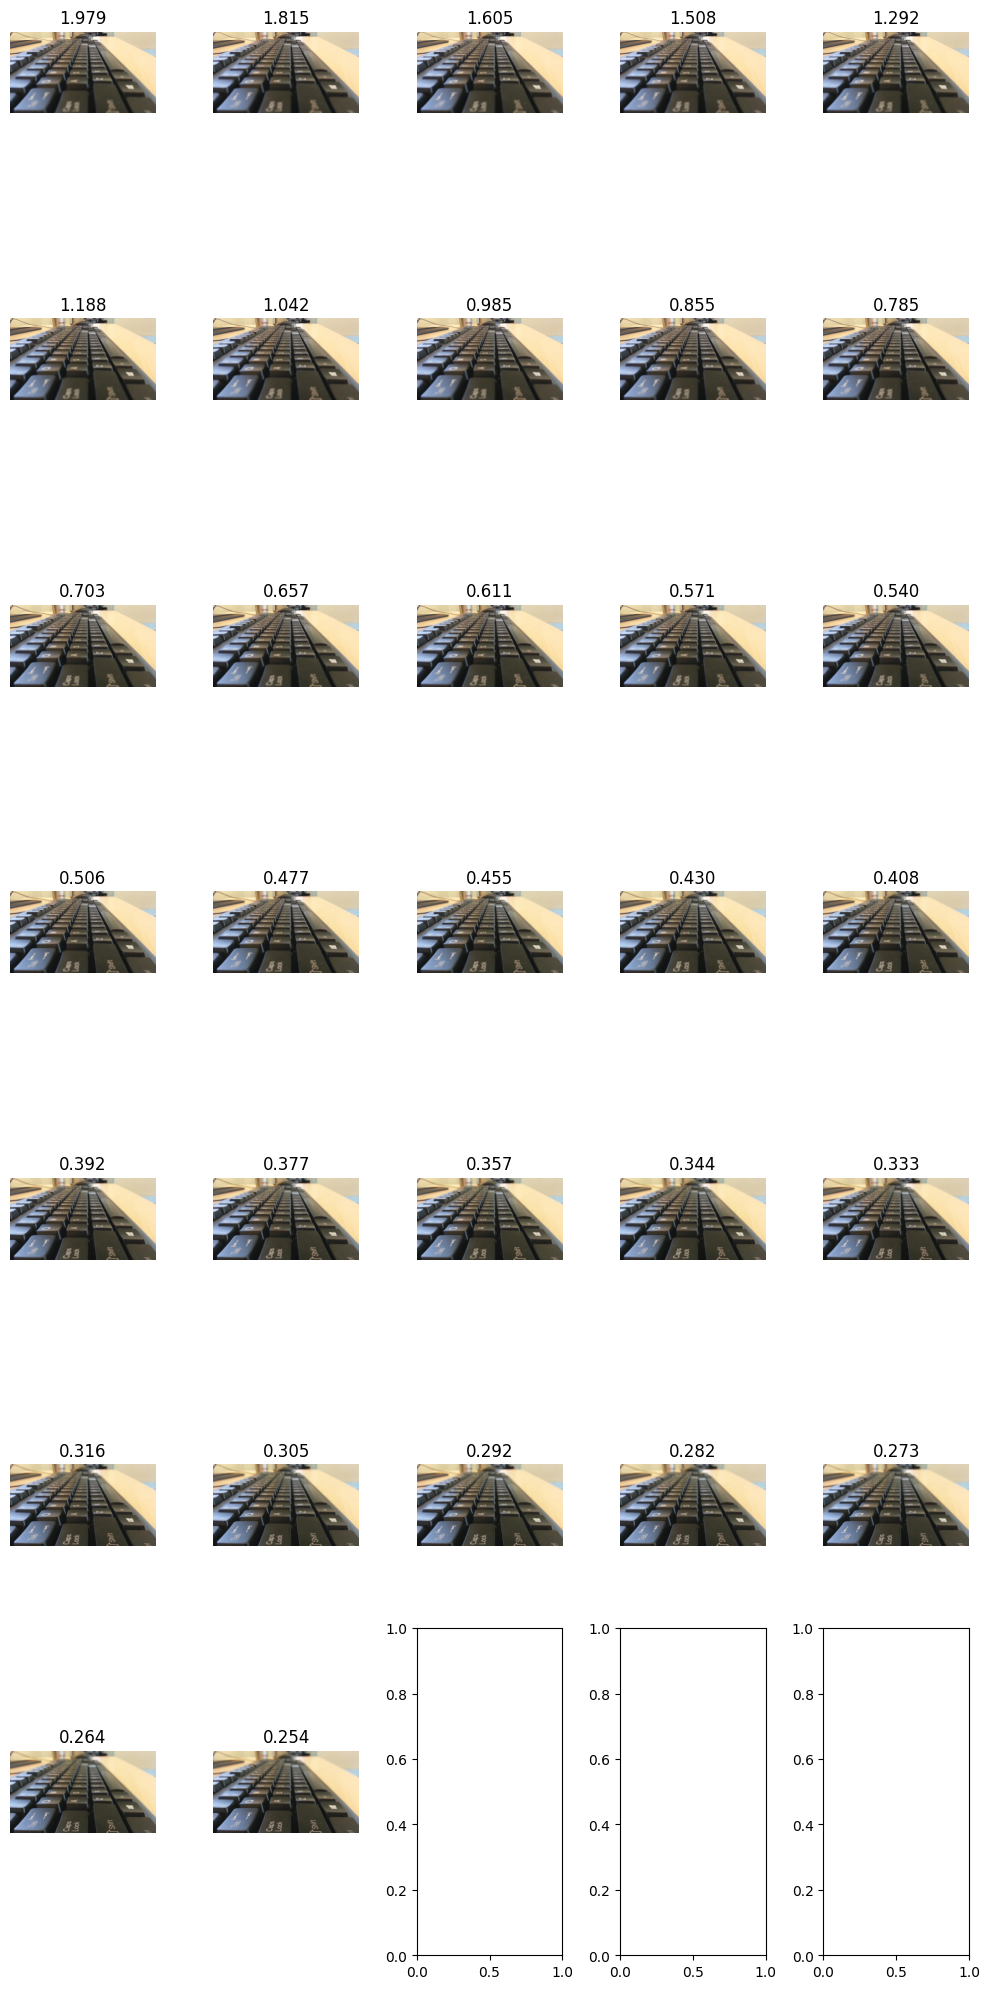

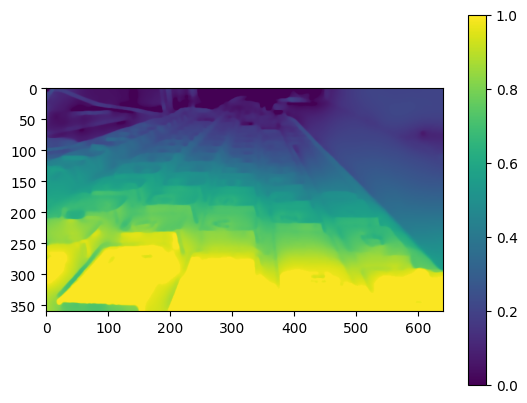

adaptive kernel size set to 11


In [2]:
globals.init_MobileDepth()

IMAGE_RANGE = 255.
example_name = "keyboard"
# ["keyboard", "bottles", "fruits", "metals", "plants", "telephone", "window", "largemotion", "smallmotion", "zeromotion", "balls"]:

defocus_stack, dpt_result, scale_mat = utils.load_single_sample_MobileDepth(example_name)

defocus_stack = np.stack([
    skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=True)
    for img in defocus_stack
], axis=0)

defocus_stack *= IMAGE_RANGE 

print(defocus_stack.shape, defocus_stack.min(), defocus_stack.max())
# globals.ps = 1.2e-5#1.4e-6#5 * 1e-3 / defocus_stack.shape[2]
# globals.ps = 7e-6 # explain how i got this, calculated from samsung galaxy s3 sensor size on internet
globals.ps = 4.54e-3 / 3264 * (3264 / defocus_stack.shape[1])
print('Pixel size:', globals.ps)


fs, width, height, _ = defocus_stack.shape
print(fs, width, height)
print(dpt_result.dtype, defocus_stack.dtype)

globals.min_Z = max(0.001, globals.Df.min() - 0.05)
globals.max_Z = min(3, globals.Df.max() + 0.5)
print('Depth range', globals.min_Z,'-', globals.max_Z)


utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

# plt.imshow(scale_mat)
# plt.colorbar()
# plt.show()

plt.imshow(dpt_result)
plt.colorbar()
plt.show()

# print(scale_mat.shape)
# print(scale_mat)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)


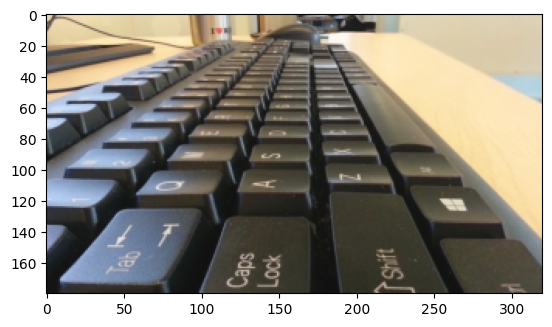

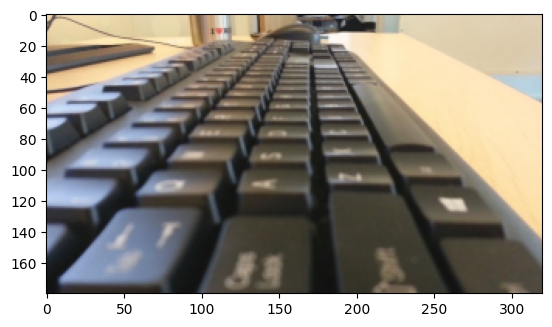

In [3]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=False, save_plots=True,
        experiment_name = 'mobile-depth-keyboard-window5', num_epochs = 40,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = globals.min_Z, max_Z = globals.max_Z,
        vmin = globals.min_Z, vmax = globals.max_Z, verbose = True,
        windowed_mse=True)


Created experiment folder: /data/holly_jackson/experiments/mobile-depth-keyboard-window5_2025-10-27_22-22-12
Images in range [0-255]
Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [01:25<00:00,  1.17it/s]


GRID SEARCH DURATION 85.88234496116638

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 97.47560167312622
Loss: 262.66248 , TV: 4334.54

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 200/200 [06:50<00:00,  2.05s/it]


r1norm 33049.258 norm(x) 57122.38
FISTA duration 433.6103527545929

AIF result range: [ 0.0 , 255.0 ]
Loss: 197.54503 , TV: 3861059.0
FULL ITER DURATION 635.2598855495453
ls_maxiter updated to 210


--------------------------

Iteration 1 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.99842548370361

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 96.50815510749817
Loss: 196.87186 , TV: 5334.413

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 210/210 [07:13<00:00,  2.06s/it]


r1norm 32983.277 norm(x) 57146.92
FISTA duration 455.21744179725647

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.75854 , TV: 3976440.2
FULL ITER DURATION 656.3828017711639
ls_maxiter updated to 220


--------------------------

Iteration 2 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.12977576255798

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.24605798721313
Loss: 196.57733 , TV: 5367.8037

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 220/220 [07:32<00:00,  2.06s/it]


r1norm 32965.156 norm(x) 57162.7
FISTA duration 474.03939032554626

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.54213 , TV: 4040554.5
FULL ITER DURATION 677.2618107795715
ls_maxiter updated to 231


--------------------------

Iteration 3 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.16528272628784

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 97.36403107643127
Loss: 196.49475 , TV: 5359.3096

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 231/231 [07:53<00:00,  2.05s/it]


r1norm 32959.2 norm(x) 57174.254
FISTA duration 495.4259674549103

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.47127 , TV: 4093723.5
FULL ITER DURATION 697.1700131893158
ls_maxiter updated to 242


--------------------------

Iteration 4 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.8523645401001

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.58619284629822
Loss: 196.45023 , TV: 5379.001

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 242/242 [08:15<00:00,  2.05s/it]


r1norm 32955.598 norm(x) 57188.574
FISTA duration 517.5052983760834

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.42828 , TV: 4156033.2
FULL ITER DURATION 720.8395280838013
ls_maxiter updated to 254


--------------------------

Iteration 5 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.6129355430603

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.82779169082642
Loss: 196.4139 , TV: 5385.5454

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 254/254 [08:41<00:00,  2.05s/it]


r1norm 32953.51 norm(x) 57196.527
FISTA duration 543.3593955039978

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.40335 , TV: 4185992.0
FULL ITER DURATION 746.768720626831
ls_maxiter updated to 266


--------------------------

Iteration 6 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.36082243919373

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.88409399986267
Loss: 196.39462 , TV: 5399.185

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 266/266 [09:04<00:00,  2.05s/it]


r1norm 32950.95 norm(x) 57203.91
FISTA duration 566.8187501430511

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.37268 , TV: 4212822.5
FULL ITER DURATION 770.0615339279175
ls_maxiter updated to 279


--------------------------

Iteration 7 



Grid search         : 100%|███████████████████| 100/100 [01:26<00:00,  1.15it/s]


GRID SEARCH DURATION 86.9917950630188

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.64458131790161
Loss: 196.36716 , TV: 5404.6934

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 279/279 [09:31<00:00,  2.05s/it]


r1norm 32949.016 norm(x) 57213.95
FISTA duration 593.6752238273621

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.34961 , TV: 4241665.0
FULL ITER DURATION 796.2579209804535
ls_maxiter updated to 292


--------------------------

Iteration 8 



Grid search         : 100%|███████████████████| 100/100 [01:26<00:00,  1.15it/s]


GRID SEARCH DURATION 86.96084666252136

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.69919013977051
Loss: 196.34546 , TV: 5407.34

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 292/292 [09:58<00:00,  2.05s/it]


r1norm 32946.754 norm(x) 57223.777
FISTA duration 620.4631862640381

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.32263 , TV: 4265522.0
FULL ITER DURATION 823.061669588089
ls_maxiter updated to 306


--------------------------

Iteration 9 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.36771821975708

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.30930280685425
Loss: 196.3132 , TV: 5408.9463

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 306/306 [10:27<00:00,  2.05s/it]


r1norm 32944.133 norm(x) 57231.48
FISTA duration 649.1795601844788

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.29138 , TV: 4280733.0
FULL ITER DURATION 851.8029069900513
ls_maxiter updated to 321


--------------------------

Iteration 10 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.7361855506897

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.54381155967712
Loss: 196.29065 , TV: 5410.7603

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 321/321 [10:57<00:00,  2.05s/it]


r1norm 32943.65 norm(x) 57238.246
FISTA duration 679.2049221992493

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.28569 , TV: 4298765.0
FULL ITER DURATION 882.4828727245331
ls_maxiter updated to 337


--------------------------

Iteration 11 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.84357452392578

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 98.98200416564941
Loss: 196.2808 , TV: 5410.2266

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 337/337 [11:30<00:00,  2.05s/it]


r1norm 32942.16 norm(x) 57246.613
FISTA duration 712.2053189277649

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.26799 , TV: 4315988.0
FULL ITER DURATION 916.3614890575409
ls_maxiter updated to 353


--------------------------

Iteration 12 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.55700063705444

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 99.04110527038574
Loss: 196.26317 , TV: 5409.5664

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 353/353 [12:03<00:00,  2.05s/it]


r1norm 32940.26 norm(x) 57253.363
FISTA duration 745.3259582519531

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.24518 , TV: 4335480.0
FULL ITER DURATION 948.9338164329529
ls_maxiter updated to 370


--------------------------

Iteration 13 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.78487992286682

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 99.88755106925964
Loss: 196.24355 , TV: 5410.5405

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 370/370 [12:38<00:00,  2.05s/it]


r1norm 32939.586 norm(x) 57256.016
FISTA duration 780.0137617588043

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.23732 , TV: 4346237.5
FULL ITER DURATION 984.8338949680328
ls_maxiter updated to 388


--------------------------

Iteration 14 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.90006828308105

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 99.97403597831726
Loss: 196.23618 , TV: 5410.775

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 388/388 [13:14<00:00,  2.05s/it]


r1norm 32938.71 norm(x) 57260.957
FISTA duration 816.4762189388275

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.22676 , TV: 4361416.0
FULL ITER DURATION 1021.4476079940796
ls_maxiter updated to 407


--------------------------

Iteration 15 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.85462141036987

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 99.83976912498474
Loss: 196.22444 , TV: 5411.911

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 407/407 [13:53<00:00,  2.05s/it]


r1norm 32938.086 norm(x) 57264.266
FISTA duration 855.5703403949738

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21938 , TV: 4372381.0
FULL ITER DURATION 1060.3834164142609
ls_maxiter updated to 427


--------------------------

Iteration 16 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.10633373260498

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 100.60454845428467
Loss: 196.21982 , TV: 5413.915

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 427/427 [14:35<00:00,  2.05s/it]


r1norm 32938.08 norm(x) 57266.516
FISTA duration 897.5759208202362

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21925 , TV: 4380773.5
FULL ITER DURATION 1103.4783329963684
ls_maxiter updated to 448


--------------------------

Iteration 17 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.01479077339172

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 99.77458882331848
Loss: 196.21916 , TV: 5413.4106

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 448/448 [15:17<00:00,  2.05s/it]


r1norm 32938.062 norm(x) 57269.066
FISTA duration 939.6813592910767

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21906 , TV: 4389480.5
FULL ITER DURATION 1145.009967327118
ls_maxiter updated to 470


--------------------------

Iteration 18 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.7828094959259

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 100.32532453536987
Loss: 196.21854 , TV: 5413.1934

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 470/470 [16:03<00:00,  2.05s/it]


r1norm 32938.023 norm(x) 57271.016
FISTA duration 985.5330762863159

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21854 , TV: 4396177.0
FULL ITER DURATION 1190.6545810699463
ls_maxiter updated to 493


--------------------------

Iteration 19 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.87132859230042

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 100.45974683761597
Loss: 196.2188 , TV: 5413.4014

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 493/493 [16:49<00:00,  2.05s/it]


r1norm 32938.035 norm(x) 57273.33
FISTA duration 1031.70911693573

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.2188 , TV: 4405259.0
FULL ITER DURATION 1237.3632764816284
ls_maxiter updated to 517


--------------------------

Iteration 20 



Grid search         : 100%|███████████████████| 100/100 [01:26<00:00,  1.15it/s]


GRID SEARCH DURATION 87.12779545783997

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 100.77574062347412
Loss: 196.21883 , TV: 5413.4775

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 517/517 [17:40<00:00,  2.05s/it]


r1norm 32938.035 norm(x) 57275.24
FISTA duration 1082.4177360534668

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21872 , TV: 4412849.0
FULL ITER DURATION 1287.6887969970703
ls_maxiter updated to 542


--------------------------

Iteration 21 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.0014660358429

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.84567356109619
Loss: 196.21857 , TV: 5413.5327

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 542/542 [18:34<00:00,  2.06s/it]


r1norm 32938.02 norm(x) 57277.19
FISTA duration 1136.8406445980072

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21848 , TV: 4420189.0
FULL ITER DURATION 1344.2261040210724
ls_maxiter updated to 569


--------------------------

Iteration 22 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.76913952827454

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.74485802650452
Loss: 196.21843 , TV: 5413.758

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 569/569 [19:25<00:00,  2.05s/it]


r1norm 32938.02 norm(x) 57278.89
FISTA duration 1187.5866885185242

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.2184 , TV: 4426353.5
FULL ITER DURATION 1394.5276627540588
ls_maxiter updated to 597


--------------------------

Iteration 23 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.93420577049255

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.44630551338196
Loss: 196.21893 , TV: 5413.6987

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 597/597 [20:23<00:00,  2.05s/it]


r1norm 32938.055 norm(x) 57280.59
FISTA duration 1245.621868610382

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21889 , TV: 4432465.0
FULL ITER DURATION 1452.4150683879852
ls_maxiter updated to 626


--------------------------

Iteration 24 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.41596961021423

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.56429624557495
Loss: 196.21857 , TV: 5413.7246

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 626/626 [21:22<00:00,  2.05s/it]


r1norm 32938.03 norm(x) 57282.38
FISTA duration 1304.5655224323273

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21857 , TV: 4438770.0
FULL ITER DURATION 1510.9302711486816
ls_maxiter updated to 657


--------------------------

Iteration 25 



Grid search         : 100%|███████████████████| 100/100 [01:26<00:00,  1.15it/s]


GRID SEARCH DURATION 87.09972357749939

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.14240336418152
Loss: 196.21843 , TV: 5413.544

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 657/657 [22:25<00:00,  2.05s/it]


r1norm 32938.016 norm(x) 57283.883
FISTA duration 1367.8972308635712

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21857 , TV: 4444191.0
FULL ITER DURATION 1573.3791925907135
ls_maxiter updated to 689


--------------------------

Iteration 26 



Grid search         : 100%|███████████████████| 100/100 [01:26<00:00,  1.15it/s]


GRID SEARCH DURATION 87.07010984420776

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.48009371757507
Loss: 196.21872 , TV: 5413.7246

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 689/689 [23:31<00:00,  2.05s/it]


r1norm 32938.035 norm(x) 57285.207
FISTA duration 1433.8920159339905

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.2187 , TV: 4449033.0
FULL ITER DURATION 1639.8191981315613
ls_maxiter updated to 723


--------------------------

Iteration 27 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.16156339645386

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 102.17835760116577
Loss: 196.21854 , TV: 5413.668

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 723/723 [24:41<00:00,  2.05s/it]


r1norm 32938.027 norm(x) 57286.707
FISTA duration 1503.2850761413574

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21857 , TV: 4454284.5
FULL ITER DURATION 1710.1032240390778
ls_maxiter updated to 759


--------------------------

Iteration 28 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.15it/s]


GRID SEARCH DURATION 87.4674916267395

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.07700872421265
Loss: 196.21854 , TV: 5413.6514

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 759/759 [25:54<00:00,  2.05s/it]


r1norm 32938.023 norm(x) 57288.195
FISTA duration 1576.3987576961517

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21857 , TV: 4459339.0
FULL ITER DURATION 1782.2836382389069
ls_maxiter updated to 796


--------------------------

Iteration 29 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.99873089790344

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 101.12811732292175
Loss: 196.2184 , TV: 5413.71

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 796/796 [27:10<00:00,  2.05s/it]


r1norm 32938.008 norm(x) 57289.453
FISTA duration 1652.6789989471436

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21843 , TV: 4463506.0
FULL ITER DURATION 1859.2635788917542
ls_maxiter updated to 835


--------------------------

Iteration 30 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.13218021392822

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 103.15038776397705
Loss: 196.21893 , TV: 5413.7646

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 835/835 [28:30<00:00,  2.05s/it]


r1norm 32938.043 norm(x) 57290.766
FISTA duration 1732.3484568595886

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21887 , TV: 4468190.5
FULL ITER DURATION 1941.274752855301
ls_maxiter updated to 876


--------------------------

Iteration 31 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.13548922538757

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 102.9485023021698
Loss: 196.2184 , TV: 5413.6704

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 876/876 [29:54<00:00,  2.05s/it]


r1norm 32938.008 norm(x) 57291.918
FISTA duration 1816.4373862743378

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21848 , TV: 4472322.0
FULL ITER DURATION 2025.7426462173462
ls_maxiter updated to 919


--------------------------

Iteration 32 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.92276692390442

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 103.08061718940735
Loss: 196.21808 , TV: 5413.6787

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 919/919 [31:22<00:00,  2.05s/it]


r1norm 32937.98 norm(x) 57292.844
FISTA duration 1904.5243928432465

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21812 , TV: 4475660.0
FULL ITER DURATION 2113.1467843055725
ls_maxiter updated to 964


--------------------------

Iteration 33 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.82264995574951

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 102.66370558738708
Loss: 196.21817 , TV: 5413.7275

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|███████████████| 964/964 [32:54<00:00,  2.05s/it]


r1norm 32937.977 norm(x) 57294.098
FISTA duration 1996.5342762470245

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.218 , TV: 4479016.5
FULL ITER DURATION 2204.637964963913
ls_maxiter updated to 1012


--------------------------

Iteration 34 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.65647983551025

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 102.88330030441284
Loss: 196.21794 , TV: 5413.8193

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|█████████████| 1012/1012 [34:32<00:00,  2.05s/it]


r1norm 32937.97 norm(x) 57295.004
FISTA duration 2094.7960152626038

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21786 , TV: 4481998.5
FULL ITER DURATION 2302.967321395874
ls_maxiter updated to 1062


--------------------------

Iteration 35 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.58970260620117

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 103.50405812263489
Loss: 196.21764 , TV: 5413.6387

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|█████████████| 1062/1062 [36:15<00:00,  2.05s/it]


r1norm 32937.953 norm(x) 57295.645
FISTA duration 2197.8505415916443

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21773 , TV: 4484591.5
FULL ITER DURATION 2406.5381965637207
ls_maxiter updated to 1115


--------------------------

Iteration 36 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.86718726158142

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 103.5373466014862
Loss: 196.21771 , TV: 5414.166

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|█████████████| 1115/1115 [38:04<00:00,  2.05s/it]


r1norm 32937.926 norm(x) 57295.89
FISTA duration 2306.7644169330597

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.2174 , TV: 4486744.0
FULL ITER DURATION 2515.9768240451813
ls_maxiter updated to 1170


--------------------------

Iteration 37 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 88.08587265014648

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 104.11508965492249
Loss: 196.21782 , TV: 5414.2856

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing: 100%|█████████████| 1170/1170 [39:56<00:00,  2.05s/it]


r1norm 32937.96 norm(x) 57296.33
FISTA duration 2418.357135295868

AIF result range: [ 0.0 , 255.0 ]
Loss: 196.21785 , TV: 4488736.5
FULL ITER DURATION 2628.3519361019135
ls_maxiter updated to 1228


--------------------------

Iteration 38 



Grid search         : 100%|███████████████████| 100/100 [01:27<00:00,  1.14it/s]


GRID SEARCH DURATION 87.87893152236938

Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 104.18903279304504
Loss: 196.21759 , TV: 5414.376

DPT result range: [ 0.2073534 , 2.47508 ]


Bounded FISTA...


Optimizing:   2%|▎              | 27/1228 [00:55<41:00,  2.05s/it]

In [ ]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

In [ ]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [ ]:
aif = aif_init
globals.thresh=0.5


In [ ]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

In [ ]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

In [ ]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])